In [46]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import disk
from scipy.signal import convolve2d, correlate
from scipy.stats import zscore
from pathlib import Path
from os.path import sep
import pandas as pd
import scipy as sp

np.random.seed(seed=3)
%config Completer.use_jedi = False  #magic to fix autocomplete issue

## Gradient stimulus comparison
#### Comparison of modulation of input images and images as shown on projector
(based on measured input->brightness curve)

In [2]:
maxBit = 255 #assuming 8bit image depth
npts = 1000

In [12]:
panGrad = (np.sin(np.linspace(0,np.pi*2,npts)) + 1) *maxBit/2
panGradLow = (np.sin(np.linspace(0,np.pi*2,npts)) + 2)*maxBit/4
panGradVeryLow = (np.sin(np.linspace(0,np.pi*2,npts)) + 4)*maxBit/8

panGradLowBright = (np.sin(np.linspace(0,np.pi*2,npts)) + 2)*maxBit/4 + maxBit/4
panGradVeryLowBright = (np.sin(np.linspace(0,np.pi*2,npts)) + 4)*maxBit/8 + 3*maxBit/8

panWidth = np.linspace(0,1,npts)

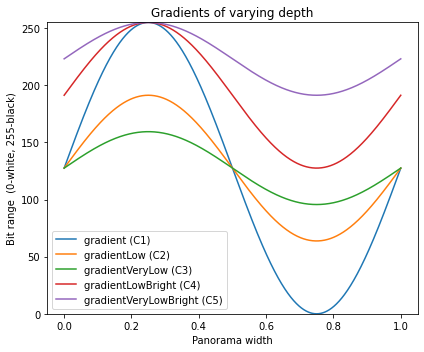

In [65]:
fig, axs = plt.subplots(1,1,figsize=(6,5))

axs.plot(panWidth,panGrad, label='gradient (C1)')
axs.plot(panWidth,panGradLow, label='gradientLow (C2)')
axs.plot(panWidth,panGradVeryLow, label='gradientVeryLow (C3)')
axs.plot(panWidth,panGradLowBright, label='gradientLowBright (C4)')
axs.plot(panWidth,panGradVeryLowBright, label='gradientVeryLowBright (C5)')
axs.set_title('Gradients of varying depth')
axs.set_ylim((0,maxBit))
axs.set_xlabel('Panorama width')
axs.set_ylabel('Bit range  (0-white, {}-black)'.format(maxBit));
axs.legend()
fig.tight_layout()

plt.savefig('./plots/gradientModulationGenerated.pdf',dpi=400)

In [60]:
Dir = 'screenMeasurements/' #"/Volumes/jayaramanlab/Shivam/" #connect to dm11
rig = "Hannah" #"Shivam"#
reversevals = False

file = rig+"Rig_lookup_table_transformed_brightness.csv"
file2 = rig+"Rig_mean_brightness.csv"

lookupDf = pd.read_csv(Dir+file)
mean_brightness = pd.read_csv(Dir+file2)

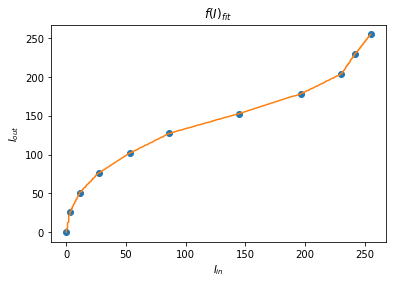

In [51]:
from scipy.optimize import minimize

y = np.array(mean_brightness['I'].values)
x = np.arange(0,256,1)
y = np.zeros(x.shape)

b = sp.interpolate.interp1d(mean_brightness['I'], mean_brightness['Stim'],bounds_error=False)

def diff(x,a):
    yt = b(x)
    return (yt - a)**2

for idx,x_value in enumerate(x):
    res = minimize(diff, 1.0, args=(x_value), method='Nelder-Mead', tol=1e-6)
    y[idx] = res.x[0]

plt.plot(mean_brightness['I'].values,mean_brightness['Stim'].values,'o');
plt.plot(np.round(y).astype('int'),x)
plt.title(r'$f(I)_{fit}$')
plt.ylabel("$I_{out}$"); plt.xlabel("$I_{in}$");

transformDf = pd.DataFrame(np.array([np.round(y).astype('int'),x]).T, columns = ["Iin", "Iout"])

In [55]:
def rescale(img):
    x = img.flatten()
    y = np.array(lookupDf.iloc[x]['Iin'])
    imgT = y.reshape(np.shape(img))
    return imgT

def simulateI(img):
    x = img.flatten()
    y = np.array(transformDf.iloc[x]['Iin'])
    imgT = y.reshape(np.shape(img))
    return imgT

No handles with labels found to put in legend.


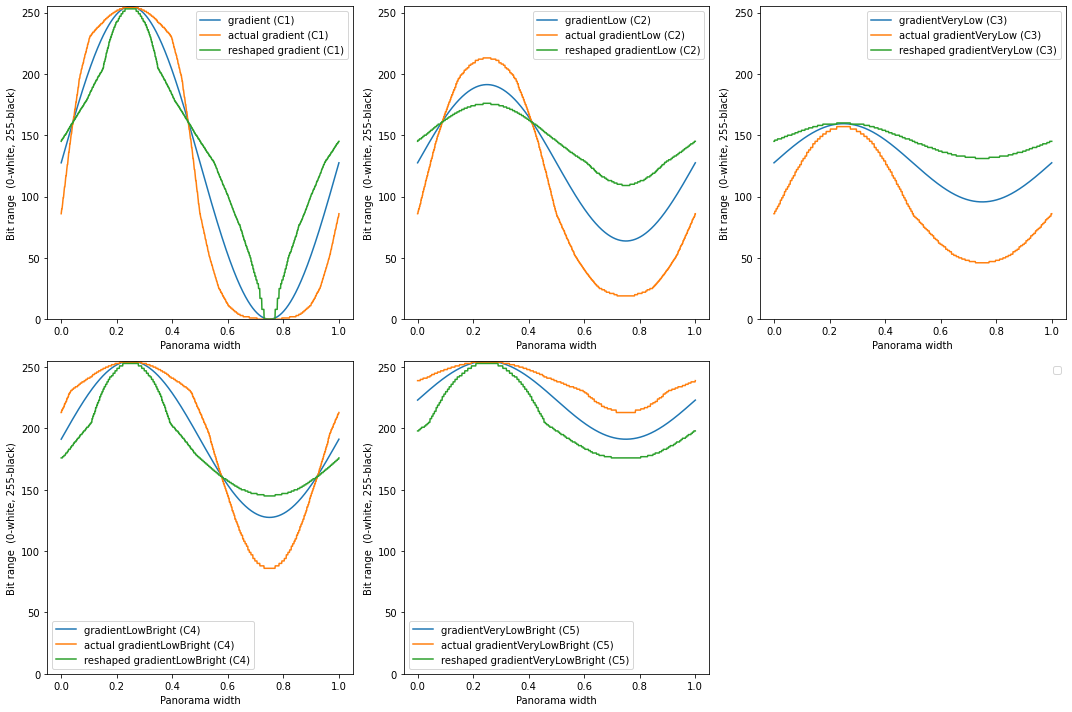

In [67]:
fig, axs = plt.subplots(2,3,figsize=(15,10))

axs[0,0].plot(panWidth,panGrad, label='gradient (C1)')
axs[0,1].plot(panWidth,panGradLow, label='gradientLow (C2)')
axs[0,2].plot(panWidth,panGradVeryLow, label='gradientVeryLow (C3)')
axs[1,0].plot(panWidth,panGradLowBright, label='gradientLowBright (C4)')
axs[1,1].plot(panWidth,panGradVeryLowBright, label='gradientVeryLowBright (C5)')

axs[0,0].plot(panWidth,simulateI(panGrad), label='actual gradient (C1)')
axs[0,1].plot(panWidth,simulateI(panGradLow), label='actual gradientLow (C2)')
axs[0,2].plot(panWidth,simulateI(panGradVeryLow), label='actual gradientVeryLow (C3)')
axs[1,0].plot(panWidth,simulateI(panGradLowBright), label='actual gradientLowBright (C4)')
axs[1,1].plot(panWidth,simulateI(panGradVeryLowBright), label='actual gradientVeryLowBright (C5)')

axs[0,0].plot(panWidth,rescale(panGrad), label='reshaped gradient (C1)')
axs[0,1].plot(panWidth,rescale(panGradLow), label='reshaped gradientLow (C2)')
axs[0,2].plot(panWidth,rescale(panGradVeryLow), label='reshaped gradientVeryLow (C3)')
axs[1,0].plot(panWidth,rescale(panGradLowBright), label='reshaped gradientLowBright (C4)')
axs[1,1].plot(panWidth,rescale(panGradVeryLowBright), label='reshaped gradientVeryLowBright (C5)')


axs[1,2].axis('off')

for i in range(3):
    for ax in axs[:,i]:
        ax.set_ylim((0,maxBit))
        ax.set_xlabel('Panorama width')
        ax.set_ylabel('Bit range  (0-white, {}-black)'.format(maxBit));
        ax.legend()
fig.tight_layout()

plt.savefig('./plots/gradientModulationRescaled_{}Rig.pdf'.format(rig),dpi=400)